In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
cleaned = pd.read_csv("processed_afl_dataset.csv")
cleaned.drop(['Unnamed: 0','GM'], axis=1, inplace=True)

In [4]:
cleaned.corr()['BR']

KI    0.480148
MK    0.222255
HB    0.550714
DI    0.583512
GL    0.274596
BH    0.291200
HO   -0.000994
TK    0.401563
RB    0.049036
IF    0.601772
CL    0.568212
CG    0.483233
FF    0.343401
FA    0.212488
BR    1.000000
CP    0.636283
UP    0.465232
CM    0.065050
MI    0.199582
1%   -0.102615
BO    0.124163
GA    0.350499
Name: BR, dtype: float64

In [5]:
cleaned[['HB','DI','IF','CL','CP','BR']].corr()

,HB,DI,IF,CL,CP,BR
HB,1.000000,0.859024,0.656623,0.783693,0.826426,0.550714
DI,0.859024,1.000000,0.725310,0.651273,0.768870,0.583512
IF,0.656623,0.725310,1.000000,0.678611,0.696912,0.601772
CL,0.783693,0.651273,0.678611,1.000000,0.876429,0.568212
CP,0.826426,0.768870,0.696912,0.876429,1.000000,0.636283
BR,0.550714,0.583512,0.601772,0.568212,0.636283,1.000000


# Training-test split (7:3)

# Polynomial Transformation (non-linear)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train, X_test, y_train, y_test = train_test_split(poly.fit_transform(cleaned[['HB','DI','IF','CL','CP']]), cleaned['BR'], test_size=0.3, random_state=42)

# Normalization

For normalization, it is common to use only the training set statistics (mean and standard deviation), and then apply these statistics to the independent variables in the training and test sets to maintain consistency in the data

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)


# Creating the linear regression model

In [8]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train_std, y_train)

LinearRegression()

# Evaluating the Regression Model

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [10]:
intercept = lm.intercept_
coefficients = lm.coef_
print('Intercept', intercept)
print('Coefficients', coefficients)

Intercept 0.08862258788716078
Coefficients [ 0.03171303 -0.01803707 -0.10400136  0.03353385 -0.15526415  0.0365066
  0.17767115 -0.01108882  0.29800676 -0.59067375 -0.15824369  0.32793077
 -0.08966254  0.10780991 -0.07596431 -0.00455087  0.09626209  0.14936835
 -0.57064762  0.65823036]


In [11]:
y_test_pred = lm.predict(X_test_std)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print(mse_test)
print(r2_test)

0.012752093014992019
0.4380351573844974


In [12]:
y_train_pred = lm.predict(X_train_std)
r2_train = r2_score(y_train, y_train_pred)
print(r2_train)

0.6826389582053651


# Residual plot

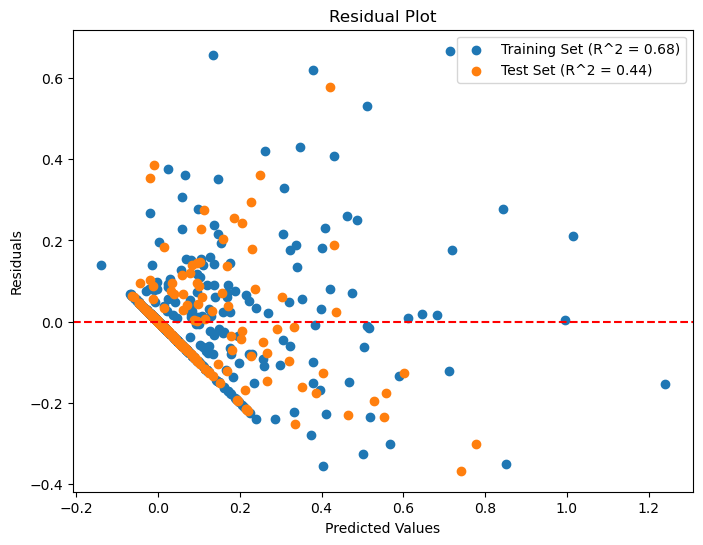

In [13]:
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_train_pred, residuals_train, label=f'Training Set (R^2 = {r2_train:.2f})')
ax.scatter(y_test_pred, residuals_test, label=f'Test Set (R^2 = {r2_test:.2f})')
ax.axhline(y=0, color='red', linestyle='--')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
ax.legend()
plt.show()

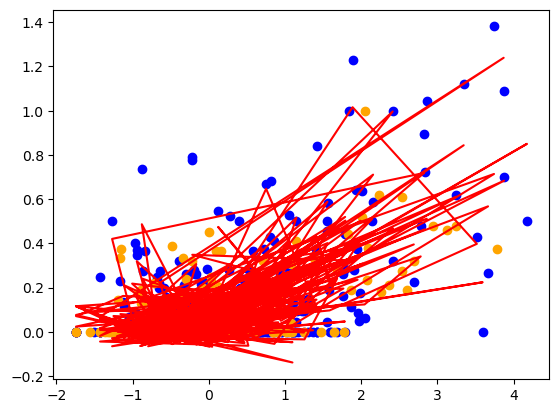

NameError: name 'y_test_pres' is not defined

In [14]:
# Visualize the actual and predicted values for the training and test sets
# Select the constant term eigenvalues for training and test sets
plt.scatter(X_train_std[:, 0], y_train, color='blue', label='Training Data')
plt.scatter(X_test_std[:, 0], y_test, color='orange', label='Testing Data')
plt.plot(X_train_std[:, 0], y_train_pred, color='red', label='Training Prediction')
plt.plot(X_test_std[:, 0], y_test_pres, color='green', label='Testing Prediction')
plt.xlabel('Feature Variables')
plt.ylabel('Brownlow Votes')
plt.legend()
plt.show()

# Bootstrapping (imbalanced data)

In [13]:
from sklearn.utils import resample

X_imb = np.array(poly.fit_transform(cleaned[['HB','DI','IF','CL','CP']]))
y_imb = cleaned['BR']
n = X_imb.shape[0]
# number of bootstrap samples
k = 500

mse_scores = []
r2_scores = []
lm_imb = LinearRegression()

# Loop through each dataset, split data based on bootstrapping indices + fit model + evaluate
for i in range(k):
    # prepare bootstrap sample
    boot_index = resample(range(n), replace=True, n_samples=n, random_state=i)
    # out of bag observations
    oob_index = [x for x in range(n) if x not in boot_index]
    # Split datasets
    X_imb_train = X_imb[boot_index,:]
    X_imb_test = X_imb[oob_index,:]
    y_imb_train = y_imb[boot_index]
    y_imb_test = y_imb[oob_index]

    # Normalization
    scaler = StandardScaler()
    scaler.fit(X_imb_train)
    X_imb_train_std = scaler.transform(X_imb_train)
    X_imb_test_std = scaler.transform(X_imb_test)

    # Train
    lm_imb.fit(X_imb_train_std, y_imb_train)
    y_imb_pred = lm_imb.predict(X_imb_test_std)

    # Evaluation
    mse_imb = mean_squared_error(y_imb_test, y_imb_pred)
    r2_imb = r2_score(y_imb_test, y_imb_pred)
    mse_scores.append(mse_imb)
    r2_scores.append(r2_imb)
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)
print(avg_mse)
print(avg_r2)

0.015325246239532941
0.5631013695723236


# Linear Regression Model 2 ('CP' only since collinearity)

In [14]:
X1 = cleaned['CP'].values.reshape(-1,1)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(poly.fit_transform(X1), cleaned['BR'], test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train_c, y_train_c)
y_pred_c_test = model.predict(X_test_c)
mse = mean_squared_error(y_test_c, y_pred_c_test)
r2_test_c = r2_score(y_test_c, y_pred_c_test)
print(mse)
print(r2_test_c)

0.013615555533427626
0.3999837114213458


In [15]:
# Prediction for training set
y_pred_c_train = model.predict(X_train_c)
r2_train_c = r2_score(y_train_c, y_pred_c_train)
print(r2_train_c)

0.4885227058963857


# Visualization

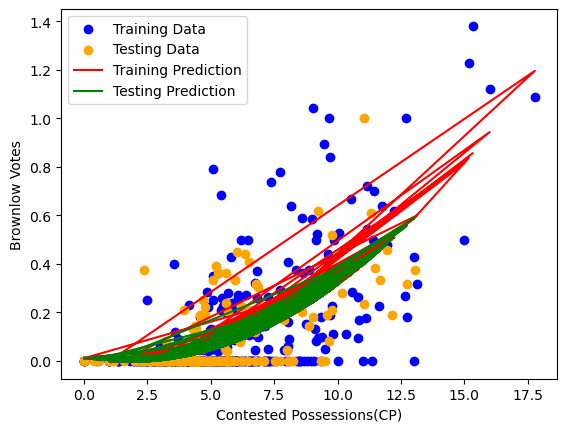

In [16]:
# Visualize the actual and predicted values for the training and test sets
# Select the constant term eigenvalues for training and test sets
plt.scatter(X_train_c[:, 0], y_train_c, color='blue', label='Training Data')
plt.scatter(X_test_c[:, 0], y_test_c, color='orange', label='Testing Data')
plt.plot(X_train_c[:, 0], y_pred_c_train, color='red', label='Training Prediction')
plt.plot(X_test_c[:, 0], y_pred_c_test, color='green', label='Testing Prediction')
plt.xlabel('Contested Possessions(CP)')
plt.ylabel('Brownlow Votes')
plt.legend()
plt.show()

# Bootstrapping

In [17]:
X_imb_c = np.array(poly.fit_transform(X1))
y_imb_c = np.array(cleaned['BR'])
n = X_imb_c.shape[0]
# number of bootstrap samples
k = 500

mse_scores = []
r2_scores = []
model_imb = LinearRegression()

# Loop through each dataset, split data based on bootstrapping indices + fit model + evaluate
for i in range(k):
    # prepare bootstrap sample
    boot_index = resample(range(n), replace=True, n_samples=n, random_state=i)
    # out of bag observations
    oob_index = [x for x in range(n) if x not in boot_index]
    # Split datasets
    X_imb_c_train = X_imb_c[boot_index]
    X_imb_c_test = X_imb_c[oob_index]
    y_imb_c_train = y_imb_c[boot_index]
    y_imb_c_test = y_imb_c[oob_index]

    # Train
    model_imb.fit(X_imb_c_train, y_imb_c_train)
    y_imb_c_pred = model_imb.predict(X_imb_c_test)

    # Evaluation
    mse_imb_c = mean_squared_error(y_imb_c_test, y_imb_c_pred)
    r2_imb_c = r2_score(y_imb_c_test, y_imb_c_pred)
    mse_scores.append(mse_imb_c)
    r2_scores.append(r2_imb_c)
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)
print(avg_mse)
print(avg_r2)

0.019538329501052616
0.4424756834850781
